# Wrangle and Analyze Data 
______

## Table of Contents
- [Introduction](#intro)
- [Importing required libraries](#import)
- [1. Gathering data](#gather)
    - [1.a Gather data via manual CSV Download](#csv)
    - [1.b Gather data via Requests library](#requests)
    - [1.c Gather data via Twitter API](#api)

- [2. Assessing data](#assess)
    - [2.a Quality issues](#assess_quality)
    - [2.b Tidiness issues](#assess_tidiness)
    - [3.c Assessment summary](#assess_summary)

- [3. Cleaning data](#clean)
    - [3.a archive dataset](#clean-achive)
        - [3.a.i  Quality issues](#clean-achive-quality)
        - [3.a.ii Tidiness issues](#clean-achive-tidiness)
    - [3.b image predictions dataset](#clean-image)
        - [3.b.i  Quality issues](#clean-image-quality)    
    - [3.c api dataset](#clean-api)
        - [3.c.i  Quality issues](#clean-api-quality)
        - [3.c.ii Tidiness issues](#clean-api-tidiness)
    - [3.d General cleaning](#clean-general)
    
- [4. Storing cleaned data](#store)

- [5. Analysis and Visualization](#analysis_vsualization)
    - [5.a Ratings analysis](#rate)
    - [5.b Favorites and retweets analysis](#fav-rt)
    - [5.c Favorites and retweets analysis by month and days](#month-day)
    - [5.d Dog stage analysis](#stage)
    - [5.e Dog breed analysis](#breed)


____

<a id='intro'></a>
## Introduction
In this project I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document my wrangling efforts in this Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and reports.

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "[they're good dogs Brent.](https://knowyourmeme.com/memes/theyre-good-dogs-brent)" WeRateDogs has over 4 million followers and has received international media coverage.
______

<a id='import'></a>
## Importing required libraries

In [1]:
# importing required libraries
import os
import json
import re
from timeit import default_timer as timer

import requests
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine


%matplotlib inline

_______

<a id='gather'></a>
## 1. Gathering data

<a id='csv'></a>
### 1.a Gather data via manual CSV Download

`twitter-archive-enhanced.csv` file was downloaded manually from WeRateDogs's twitter archive.

In [2]:
# load the csv file
archive_df = pd.read_csv('twitter-archive-enhanced.csv')
archive_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
578,800751577355128832,NaN,NaN,2016-11-21 17:23:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Mauve and Murphy. They're rather ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800751577...,12,10,Mauve,None,None,None,None
1780,677700003327029250,NaN,NaN,2015-12-18 04:00:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ralph. He's an interpretive dancer. 10...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/677700003...,10,10,Ralph,None,None,None,None
764,777953400541634568,NaN,NaN,2016-09-19 19:31:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Gerald. He's a fairly exot...,7.681934e+17,4.196984e+09,2016-08-23 21:09:14 +0000,https://twitter.com/dog_rates/status/768193404...,8,10,Gerald,doggo,None,None,None
1554,688898160958271489,NaN,NaN,2016-01-18 01:38:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you have a ton of work to do but then rem...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688898160...,10,10,None,None,None,None,None
1692,681302363064414209,NaN,NaN,2015-12-28 02:35:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Chuck. He's a neat dog. Very flexible....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/681302363...,3,10,Chuck,None,None,None,None


In [3]:
# Exploring columns
list(archive_df)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

<a id='requests'></a>
### 1.b Gather data via Requests library

Gathering additional data using `requests` library to download `image-predictions.tsv` file using provided `url`.

`image-predictions.tsv` is a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [4]:
# variables
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = url.split('/')[-1]

# response
r = requests.get(url)
# print(r.status_code)

# writing the content to a file
# first: Check if the file is already exist
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)

In [5]:
# load the file to dataframe
image_predictions_df = pd.read_csv(file_name, sep='\t')
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# Exploring columns
list(image_predictions_df)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

<a id='api'></a>
### 1.c Gather data via Twitter API

Gathering additional data from Twitter API to get additional information about the tweets we have in `archive_df` using `tweet_id`

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
if not os.path.isfile('tweet_json.txt'):
    with open('tweet_json.txt', 'w') as outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.TweepError as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
end = timer()
print(end - start)
print(fails_dict)

0.0004244999999993837
{}


Creating `api_df` dataframe from the json file.

In [8]:
# list of dictionaries
tweets_data = []

with open('tweet_json.txt', 'r') as f:
    for line in f:
        tweet_data = json.loads(line)
        tweets_data.append(tweet_data)
        
api_df = pd.DataFrame(tweets_data)

In [9]:
# Exploring columns
list(api_df)

['created_at',
 'id',
 'id_str',
 'full_text',
 'truncated',
 'display_text_range',
 'entities',
 'extended_entities',
 'source',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'possibly_sensitive',
 'possibly_sensitive_appealable',
 'lang',
 'retweeted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'quoted_status']

Since we don't need all these columns. We are going to use only three columns and drop the others.
- `id` 
- `retweet_count`
- `favorite_count`

In [10]:
api_df = api_df[['id', 'retweet_count', 'favorite_count']]

In [11]:
api_df.head()

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [12]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB



______

<a id='assess'></a>
## 2. Assessing data

**We can assess data for:**

- **Quality:** issues with content. Low quality data is also known as dirty data.
- **Tidiness:** issues with structure that prevent easy analysis. Untidy data is also known as messy data.

**... Using two types of assessment:**

- **Visual assessment:** scrolling through the data.
- **Programmatic assessment:** using code to view specific portions and summaries of the data (pandas' `head`, `tail`, and `info` methods, for example).

<a id='assess_quality'></a>
### 2.a Quality issues

- **Quality issues** pertain to the content of data. Low quality data is also known as dirty data. There are four dimensions of quality data:<br><br>

    - **Completeness:** do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?
    - **Validity**: we have the records, but they’re not valid, i.e., they don’t conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).
    - **Accuracy**: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient’s weight that is 5 lbs too heavy because the scale was faulty.
    - **Consistency**: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.
    _____

#### 2.a.i archive_df table

In [13]:
archive_df.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
27,886736880519319552,NaN,NaN,2017-07-16 23:58:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mingus. He's a wonderful father to his...,NaN,NaN,NaN,"https://www.gofundme.com/mingusneedsus,https:/...",13,10,Mingus,None,None,None,None
1844,675849018447167488,6.758457e+17,4.196984e+09,2015-12-13 01:25:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This dog is being demoted to a 9/10 for not we...,NaN,NaN,NaN,NaN,9,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None


In [14]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

- Erroneous datatype:
    - timestamp and retweeted_status_timestamp should be datetime
    - tweet_id should be string
    - Doggo, floofer, pupper, and puppo are categories.

In [15]:
archive_df.tweet_id.duplicated().any()

False

In [16]:
archive_df[['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [17]:
archive_df.query('rating_numerator == 1776')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
979,This is Atticus. He's quite simply America af....,1776,10


In [18]:
archive_df.query('rating_denominator != 10')[['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50


In [19]:
archive_df.rating_denominator.sort_values(ascending=False)

1120    170
902     150
1634    130
1779    120
1635    110
       ... 
1575     10
1576     10
516       7
2335      2
313       0
Name: rating_denominator, Length: 2356, dtype: int64

In [20]:
archive_df.rating_numerator.sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
        ... 
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

- invalid and inconsistent rating data is both `rating_numerator` and `rating_denominator`

In [21]:
archive_df.name.value_counts()

None       745
a           55
Charlie     12
Oliver      11
Lucy        11
          ... 
Ember        1
Charl        1
Tango        1
Jazz         1
Chubbs       1
Name: name, Length: 957, dtype: int64

_______

In [22]:
# default
# pd.set_option('display.max_colwidth', 50)
# max
pd.set_option('display.max_colwidth', None)

________

In [23]:
# Checking names
# name == a
archive_df.query('name == "a"')[['tweet_id','text','name']].head()

,tweet_id,text,name
56,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
649,792913359805018113,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
801,772581559778025472,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
1002,747885874273214464,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
1004,747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a


In [24]:
archive_df.name.sort_values()

1035     Abby
1021     Abby
938       Ace
1933     Acro
1327    Adele
        ...  
1031     very
773      very
1097     very
819      very
1385     very
Name: name, Length: 2356, dtype: object

In [25]:
# name == an
archive_df.query('name == "an"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
759,778396591732486144,RT @dog_rates: This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
1025,746369468511756288,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,an
1362,703041949650034688,This is an East African Chalupa Seal. We only rate dogs. Please only send in dogs. Thank you... 10/10 https://t.co/iHe6liLwWR,an
2204,668636665813057536,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,an
2333,666337882303524864,This is an extremely rare horned Parthenon. Not amused. Wears shoes. Overall very nice. 9/10 would pet aggressively https://t.co/QpRjllzWAL,an
2335,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,an
2349,666051853826850816,This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,an


In [26]:
# name == the
archive_df.query('name == "the"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
1527,690360449368465409,Stop sending in lobsters. This is the final warning. We only rate dogs. Thank you... 9/10 https://t.co/B9ZXXKJYNx,the
1603,685943807276412928,This is the newly formed pupper a capella group. They're just starting out but I see tons of potential. 8/10 for all https://t.co/wbAcvFoNtn,the
1797,677269281705472000,This is the happiest pupper I've ever seen. 10/10 would trade lives with https://t.co/ep8ATEJwRb,the
1815,676613908052996102,This is the saddest/sweetest/best picture I've been sent. 12/10 😢🐶 https://t.co/vQ2Lw1BLBF,the
2037,671561002136281088,This is the best thing I've ever seen so spread it like wildfire &amp; maybe we'll find the genius who created it. 13/10 https://t.co/q6RsuOVYwU,the
2212,668587383441514497,Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,the
2345,666063827256086533,This is the happiest dog you will ever see. Very committed owner. Nice couch. 10/10 https://t.co/RhUEAloehK,the
2346,666058600524156928,Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,the


In [27]:
# name == very 
archive_df.query('name == "very"')[['tweet_id', 'text', 'name']]

,tweet_id,text,name
773,776249906839351296,RT @dog_rates: We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10 https://…,very
819,770655142660169732,We only rate dogs. Pls stop sending in non-canines like this Arctic Floof Kangaroo. This is very frustrating. 11/10 https://t.co/qlUDuPoE3d,very
1031,745422732645535745,We only rate dogs. Pls stop sending in non-canines like this Jamaican Flop Seal. This is very very frustrating. 9/10 https://t.co/nc53zEN0hZ,very
1097,736225175608430592,We only rate dogs. Please stop sending in non-canines like this Alaskan Flop Turtle. This is very frustrating. 10/10 https://t.co/qXteK6Atxc,very
1385,700747788515020802,We only rate dogs. Pls stop sending in non-canines like this Mongolian grass snake. This is very frustrating. 11/10 https://t.co/22x9SbCYCU,very


- Invaled names in `name` column. (a, an, the, very)

In [28]:
archive_df.query('(doggo != "None")')['name'].count()

97

In [29]:
archive_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [30]:
archive_df.query('(floofer != "None")')['name'].count()

10

In [31]:
archive_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [32]:
archive_df.query('(pupper != "None")')['name'].count()

257

In [33]:
archive_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [34]:
archive_df.query('(puppo != "None")')['name'].count()

30

In [35]:
archive_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [36]:
 archive_df.query('(doggo != "None") & (floofer != "None")')[['text','name', 'doggo','floofer', 'pupper','puppo']]

,text,name,doggo,floofer,pupper,puppo
200,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",None,doggo,floofer,None,None


#### 2.a.ii image_predictions_df table

In [37]:
image_predictions_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [38]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- ('p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog') Columns names are not informative. Names should be changed to be more informative.
- Erroneous datatypes:
    - p1, p2 and p3 should be categorical
    - tweet_id should be string

In [39]:
image_predictions_df.tweet_id.duplicated().any()

False

In [40]:
image_predictions_df.jpg_url.duplicated().any()

True

In [41]:
image_predictions_df[image_predictions_df.jpg_url.duplicated()]['tweet_id']

1297    752309394570878976
1315    754874841593970688
1333    757729163776290825
1345    759159934323924993
1349    759566828574212096
               ...        
1903    851953902622658560
1944    861769973181624320
1992    873697596434513921
2041    885311592912609280
2055    888202515573088257
Name: tweet_id, Length: 66, dtype: int64

In [42]:
# Check tweets_id existance in both archive_df & image_predictions_df
image_predictions_df.tweet_id.isin(archive_df.tweet_id).all()

True

In [43]:
# Check tweets_id existance in both api_df & image_predictions_df
image_predictions_df.tweet_id.isin(api_df.id).all()

False

- missing tweets data 

In [44]:
image_predictions_df.img_num.sort_values(ascending=False)

2040    4
1713    4
1768    4
1496    4
1978    4
       ..
1292    1
1293    1
1294    1
1295    1
0       1
Name: img_num, Length: 2075, dtype: int64

#### 2.a.iii api_df table

In [45]:
api_df.head(3)

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461


In [46]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


- Erroneous datatype
    - id should be string
- id should be tweet_id

In [47]:
api_df.id.duplicated().any()

False

In [48]:
# Comparing dataframes shapes
print(f"archive_df's shape: \n{archive_df.shape}\n")
print(f"image_predictions_df's shape: \n{image_predictions_df.shape}\n")
print(f"api_df's shape: \n{api_df.shape}")

archive_df's shape: 
(2356, 17)

image_predictions_df's shape: 
(2075, 12)

api_df's shape: 
(2354, 3)


- dataframes do not have the same number of data

<a id='assess_tidiness'></a>
### 2.b Tidiness issues

- **Tidiness issues** pertain to the structure of data. These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:<br><br>
    - Each variable forms a column.
    - Each observation forms a row.
    - Each type of observational unit forms a table.

#### 2.b.i archive_df table

In [49]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


- (doggo, floofer, pupper, puppo) should be categories of a single variable named "dog_stage".

#### 2.b.ii image_predictions_df table

In [50]:
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 2.b.iii api_df table

In [51]:
api_df.head() 

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


- archive_df and api_df should be merged into one table on `tweet_id`

<a id='assess_summary'></a>
### 2.c Assessment summary<br>

- **2.c.i Quality**<br><br>
    - **archive_df table:**
        - Erroneous datatype:
            * timestamp and retweeted_status_timestamp should be datetime.
            * tweet_id should be string.
            * (doggo, floofer, pupper, and puppo) are categories.
        - Inconsistent representation of `null` values as "None" strings in the (`name`, `doggo`, `floofer`, `pupper`, `puppo`) columns.
        - Invalid records: tweets in (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`) as they mean that they are not  original tweets and should not be included in analysis.
        - Incorrect names in the `name` column, names weren't successfully extracted from the text. i.e. (a, an, the, very).
        - Missing records in (`in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`,`expanded_url`, `doggo`, `floofer`, `pupper`, `puppo`).
        - Some tweets may not have any images and should be dropped (number of tweets between the archive_df dataset and the image_prediction_df).
        - Some tweets are not original tweets, they are retweets or replies and should be dropped.
        - Invalid or inconsistent rating data is both `rating_numerator` and `rating_denominator`<br><br>

    - **image_predictions_df table**
        - Erroneous datatypes:
            - tweet_id should be string.
        - Columns names are not informative. Names should be changed to be more informative.
        - Duplicated `jpg_url` records.
        - Missing records; indicates that there are tweets without images should be dropped.<br><br>

    - **api_df table**
        - Erroneous datatype
            - id should be string
        - dataframes do not have the same number of data.<br>
____
- **2.c.ii Tidiness**<br><br>
    - **archive_df table:**
        - (`doggo`, `floofer`, `pupper`, `puppo`) should be categories of a one variable named "`dog_stage`".
    - **General:**
        - `archive_df` and api_df should be merged into one table on tweet_id
        - `image_predictions_df` can be left as-is, because the observational units are images.
        
 ____

<a id='clean'></a>
## 3. Cleaning data

Before cleaning steps, a good practice is working on a copy of each data set.

In [52]:
# make copies of the dataframes
archive_clean = archive_df.copy() 
image_predictions_clean = image_predictions_df.copy()
api_clean = api_df.copy()

<a id='clean-achive'></a>
### 3.a `archive_clean` dataset
<a id='clean-achive-quality'></a>
###  3.a.i Quality issues

**3.a.i.1. archive_clean: `name` column:**

- Incorrect/invalid names. (a, an, the, very)
- Some names weren't successfully extracted trom the text. (index 391)
- Inconsistent representation of null values as "None" string.

**Define**
- Fix missing name in index 391. (manually)
- Fix invalid names (a, an, the, very). Extract correct names (if availavle) from `text`. 
- Replace "None" string with null value.

**Code**

In [53]:
# default
# pd.set_option('display.max_colwidth', 50)
# max
# pd.set_option('display.max_colwidth', None)

In [54]:
# Checking index 391
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX",None


In [55]:
archive_clean.loc[391,'name'] = 'Dew'

In [56]:
# Samples of names that are "a, an, the, very"
archive_clean.query('(name == "a") | (name == "an") | (name == "the") | (name == "very")')[['text', 'name']].sample(25)

,text,name
2311,This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa,a
1923,This is a Sagitariot Baklava mix. Loves her new hat. 11/10 radiant pup https://t.co/Bko5kFJYUU,a
2212,Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,the
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,a
2350,This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,a
1877,C'mon guys. We've been over this. We only rate dogs. This is a cow. Please only submit dogs. Thank you...... 9/10 https://t.co/WjcELNEqN2,a
2191,This is a Slovakian Helter Skelter Feta named Leroi. Likes to skip on roofs. Good traction. Much balance. 10/10 wow! https://t.co/Dmy2mY2Qj5,a
1785,This is a dog swinging. I really enjoyed it so I hope you all do as well. 11/10 https://t.co/Ozo9KHTRND,a
2249,This is a Shotokon Macadamia mix named Cheryl. Sophisticated af. Looks like a disappointed librarian. Shh (lol) 9/10 https://t.co/J4GnJ5Swba,a
2347,My oh my. This is a rare blond Canadian terrier on wheels. Only $8.98. Rather docile. 9/10 very rare https://t.co/yWBqbrzy8O,a


In [57]:
archive_clean.loc[1193,['name']]

name    a
Name: 1193, dtype: object

From the `text`; I've noticed that the correct name is usally after 'named' or 'name is', others do not have names.

In [58]:
# Using regualar exepressions to extract the correct name
# Test pattern
test_text_01 = "This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN"
test_pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

try:
    print(re.findall(test_pattern, test_text_01)[0])
except Exception as e:
    print("Name not found")
    print(e)

Hemry


In [59]:
test_text_02 = "Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR"
try:
    print(re.findall(test_pattern, test_text_02)[0])
except Exception as e:
    print("Name not found")
    print(e)

Name not found
list index out of range


Works well!

In [60]:
# Creating a function to correct names -if available-

def correct_names(row):
    """Replace incorrect names with: 
        - Correct name extracted from text column using regex pattern.
        - 'None' if name is not availabe in text column"""
    
    if row['name'] == "a" or row['name'] == "an" or row['name'] == "the" or row['name'] == "very":
        pattern = re.compile(r'(?:name(?:d)?\s)(?:is\s)?(\w+)')

        try:
            correct_name = re.findall(pattern, row['text'])[0]
            
            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)

        except Exception as e:
            correct_name = "None"

            row['name'] = row['name'].replace('an', correct_name)
            row['name'] = row['name'].replace('a', correct_name)
            row['name'] = row['name'].replace('the', correct_name)
            row['name'] = row['name'].replace('very', correct_name)
        
        return row
    
    else:
        return row

In [61]:
# Applying the function
archive_clean = archive_clean.apply(correct_names, axis=1)

Replace "None" Sting with `None`

In [62]:
archive_clean['name'] = archive_clean.name.replace({'None': None})

**Test**

In [63]:
# Test manually fixed names
archive_clean.loc[[391],['text', 'name']]

,text,name
391,"Here's a little more info on Dew, your favorite roaming doggo that went h*ckin viral. 13/10 \nhttps://t.co/1httNYrCeW https://t.co/KvaM8j3jhX",Dew


In [64]:
# Test (a, an, the, very) names
archive_clean.loc[[2346, 2034, 2161, 2125, 2204, 2273, 2198], ['text', 'name']]

,text,name
2346,Here is the Rand Paul of retrievers folks! He's probably good at poker. Can drink beer (lol rad). 8/10 good dog https://t.co/pYAJkAe76p,None
2034,This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,Jacob
2161,This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https://t.co/eCRdwouKCl,Alfredo
2125,This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,Cherokee
2204,This is an Irish Rigatoni terrier named Berta. Completely made of rope. No eyes. Quite large. Loves to dance. 10/10 https://t.co/EM5fDykrJg,BertBerta
2273,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,Kohl
2198,This is a wild Toblerone from Papua New Guinea. Mouth always open. Addicted to hay. Acts blind. 7/10 handsome dog https://t.co/IGmVbz07tZ,None


In [65]:
archive_clean.query('(name == "a") | (name == "an") | (name == "the") | (name == "very")')[['text', 'name']]

,text,name


In [66]:
# Check "None"
archive_clean.query('(name == "None")')[['text', 'name']]

,text,name


In [67]:
archive_clean.name.isnull().sum()

798

**3.a.i.2. archive_clean: Erroneous datatypes:** 

- `tweet_id` should be a string.
- timestamp and retweeted_status_timestamp should be `datetime`.

**Define**
- Convert `tweet_id` dtype to `object` using `astype()`.
- Convert `timestamp` and `retweeted_status_timestamp` using `to_datetime()`.

**Code**

In [68]:
# tweet_id
archive_clean.tweet_id = archive_clean.tweet_id.astype(object)

In [69]:
# timestamp and retweeted_status_timestamp
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_timestamp = pd.to_datetime(archive_clean.retweeted_status_timestamp)

**Test**

In [70]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

**3.a.i.3. archive_clean: `expanded_url` Missing values :** 
- Missing values. (2297 insted of 2356)
- After inspecting; It turns out that these tweets have no images.
- Since we need only tweets with images in our analysis, these rows should be dropped.

**Define**

- Drop `NaN` values using `dropna`.

**Code**

In [71]:
# use subset
archive_clean.dropna(subset=['expanded_urls'], inplace=True)

**Test**

In [72]:
archive_clean.expanded_urls.isnull().all()

False

**3.a.i.4. archive_clean: `doggo, floofer,...` Missing values :** 

**Define**
- Fix "None" representation for later tidiness issue.

**Code**

In [73]:
archive_clean.iloc[:, -4:].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,None,None,None,None
freq,2203,2287,2042,2268


In [74]:
archive_clean.iloc[:, -4: ] = archive_clean.iloc[:, -4: ].replace("None", '')

**Test**

In [75]:
archive_clean.iloc[:, -4: ].describe()

,doggo,floofer,pupper,puppo
count,2297,2297,2297,2297
unique,2,2,2,2
top,,,,
freq,2203,2287,2042,2268


In [76]:
archive_clean.doggo.value_counts()

         2203
doggo      94
Name: doggo, dtype: int64

<a id='clean-achive-tidiness'></a>
###  3.a.ii Tidiness issues

**3.a.ii.1. archive_clean: Values represented as variables:** 

- (doggo, floofer, pupper and puppo) columns should be one category column. (dog_stage)

**Define**
- Create `dog_stage` column.
- Fix double values.
- Convert `dog_stage` dtype to `category`.

**Code**

In [77]:
archive_clean['dog_stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [78]:
# Dropping old columns
archive_clean.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

**Test**

In [79]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

In [80]:
archive_clean.dog_stage.value_counts()

                1923
pupper           243
doggo             80
puppo             28
doggopupper       12
floofer            9
doggopuppo         1
doggofloofer       1
Name: dog_stage, dtype: int64

In [81]:
# fixing double stages
archive_clean.loc[archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo-pupper'
archive_clean.loc[archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo-puppo'
archive_clean.loc[archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo-floofer'

In [82]:
# fixing empty stings values with NaN
archive_clean.loc[archive_clean.dog_stage == "", 'dog_stage'] = np.nan

In [83]:
# Convert dog_stage to category
archive_clean.dog_stage = archive_clean.dog_stage.astype('category')

**Test**

In [84]:
archive_clean.dog_stage.value_counts(dropna=False)

NaN              1923
pupper            243
doggo              80
puppo              28
doggo-pupper       12
floofer             9
doggo-puppo         1
doggo-floofer       1
Name: dog_stage, dtype: int64

In [85]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

<a id='clean-image'></a>
### 3.b `image_predictions_clean` dataset


<a id='clean-image-quality'></a>
###  3.b.i Quality issues

**3.b.i.1. image_predictions_clean: columns' names:** 
- Columns names are not informative. Names should be changed to be more informative

**Define**
- Renaming the columns to be more descriptive.

**Code**

In [86]:
# Old columns' names
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [87]:
# New descriptive columns' names
columns = ['tweet_id', 'jpg_url', 'img_num',
           'prediction_1', 'confidence_1', 'is_dog_1', 
           'prediction_2', 'confidence_2', 'is_dog_2',
           'prediction_3', 'confidence_3', 'is_dog_3',]

image_predictions_clean.columns = columns

**Test**

In [88]:
list(image_predictions_clean)

['tweet_id',
 'jpg_url',
 'img_num',
 'prediction_1',
 'confidence_1',
 'is_dog_1',
 'prediction_2',
 'confidence_2',
 'is_dog_2',
 'prediction_3',
 'confidence_3',
 'is_dog_3']

**3.b.i.2. image_predictions_clean: Erroneous datatypes:** 

- tweet_id should be a string.

**Define**
- Convert `tweet_id` dtype to `object` using `astype()`.

**Code**

In [89]:
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(object)

**Test**

In [90]:
image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      2075 non-null   object 
 1   jpg_url       2075 non-null   object 
 2   img_num       2075 non-null   int64  
 3   prediction_1  2075 non-null   object 
 4   confidence_1  2075 non-null   float64
 5   is_dog_1      2075 non-null   bool   
 6   prediction_2  2075 non-null   object 
 7   confidence_2  2075 non-null   float64
 8   is_dog_2      2075 non-null   bool   
 9   prediction_3  2075 non-null   object 
 10  confidence_3  2075 non-null   float64
 11  is_dog_3      2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


<a id='clean-api'></a>
### 3.c `api_clean` dataset


<a id='clean-api-quality'></a>
###  3.c.i Quality issues

**3.c.i.1. api_clean: `id` datatype**

- Erroneous datatype: id should be string

**Define**
- Convert `tweet_id` datatype to `object`

**Code**

In [91]:
api_clean.id = api_clean.id.astype(object)

**Test**

In [92]:
api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


<a id='clean-api-tidiness'></a>
###  3.c.ii Tidiness issues

####  3.c.ii.1 api_clean: Should be merged with archive_clean

**Define**
- Merge `api_clean` with `archive_clean`.

**Code**

In [93]:
archive_clean = pd.merge(left=archive_clean, right=api_clean, how='left', left_on='tweet_id', right_on='id')

In [94]:
# drop 'id' column
archive_clean.drop(columns=['id'], inplace=True)

**Test**

In [95]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2297 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2297 non-null   datetime64[ns, UTC]
 4   source                      2297 non-null   object             
 5   text                        2297 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2297 non-null   int64           

<a id='clean-general'></a>
## 3.d General cleaning

#### 3.d.i. Tweets without images should be removed

**Define** 
- Use  `iamge_prediction_clean` table to idintify the tweets without images in the archive table and remove them. 

**Code**

In [96]:
# Number of tweets with images
tweets_with_images = list(image_predictions_clean.tweet_id.unique())
len(tweets_with_images)

2075

In [97]:
# Checkin that all tweets are in archive_clean data set
archive_clean.tweet_id.isin(tweets_with_images).sum()

2075

In [98]:
# Dropping the other tweets
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_images)]

**Test**

In [99]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2296
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2075 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2075 non-null   datetime64[ns, UTC]
 4   source                      2075 non-null   object             
 5   text                        2075 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               2075 non-null   object             
 10  rating_numerator            2075 non-null   int64           

#### 3.d.ii. Non original tweets removal (retweets and replies):

**Define**
- Drop tweet that are not original tweets using `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`.

**Code**

In [100]:
# getting retweets
retweets = archive_clean.retweeted_status_id.notnull()
archive_clean[retweets].shape[0]

81

In [101]:
# dropping retweets
archive_clean = archive_clean[~retweets]

In [102]:
# getting replies
replies = archive_clean.in_reply_to_status_id.notnull()
archive_clean[replies].shape[0]

23

In [103]:
# dropping replies
archive_clean = archive_clean[~replies]

In [104]:
# Dropping retweets and replies columns
archive_clean.drop(columns=['in_reply_to_status_id', 
                    'in_reply_to_user_id', 
                    'retweeted_status_id', 
                    'retweeted_status_user_id', 
                    'retweeted_status_timestamp'], inplace=True)

**Test**

In [105]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2296
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1971 non-null   object             
 1   timestamp           1971 non-null   datetime64[ns, UTC]
 2   source              1971 non-null   object             
 3   text                1971 non-null   object             
 4   expanded_urls       1971 non-null   object             
 5   rating_numerator    1971 non-null   int64              
 6   rating_denominator  1971 non-null   int64              
 7   name                1397 non-null   object             
 8   dog_stage           303 non-null    category           
 9   retweet_count       1971 non-null   float64            
 10  favorite_count      1971 non-null   float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 171.7+ KB

#### 3.d.ii. Rating numerator and denominator inaccurate and invalid values:

**Define**
1. For denominator: Check values below or above 10 and its text.
2. For numerator: Check values below 6 and above 15 and its text.
3. Combined manual and programmatic fixation - if possible.

**Code**

In [106]:
# describe
archive_clean.loc[:,['rating_numerator', 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,1971.000000,1971.000000
mean,12.223237,10.477423
std,41.634034,6.853275
min,0.000000,2.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [107]:
# numerator
archive_clean.rating_numerator.unique()

array([  13,   12,   14,    5,   11,    6,   10,    0,   84,   24,   75,
         27,    3,    7,    8,    9,    4,  165, 1776,  204,   50,   99,
         80,   45,   60,   44,  121,   26,    2,  144,   88,    1,  420],
      dtype=int64)

In [108]:
archive_clean.rating_numerator.value_counts()

12      446
10      417
11      392
13      253
9       150
8        95
7        52
5        33
14       33
6        32
3        19
4        16
2         9
1         5
1776      1
24        1
26        1
420       1
27        1
44        1
45        1
50        1
60        1
75        1
80        1
84        1
88        1
99        1
121       1
144       1
165       1
204       1
0         1
Name: rating_numerator, dtype: int64

In [109]:
# denominator
archive_clean.rating_denominator.unique()

array([ 10,  70,   7, 150,  11, 170,  20,  50,  90,  80,  40, 110, 120,
         2], dtype=int64)

In [110]:
archive_clean.rating_denominator.value_counts()

10     1954
50        3
80        2
11        2
170       1
150       1
120       1
110       1
90        1
70        1
40        1
20        1
7         1
2         1
Name: rating_denominator, dtype: int64

In [111]:
# Capturing outliers
odd_numerator = np.logical_or(archive_clean.rating_numerator > 15, archive_clean.rating_numerator <= 5)
odd_denominator = np.logical_or(archive_clean.rating_denominator > 10, archive_clean.rating_denominator < 10)

In [112]:
odd_denominator.sum()

17

In [113]:
odd_numerator.sum()

101

**Observations:**
1. There are 101 odd numerators' values and 17 odd denominators' values need to be checked along with their text.


In [114]:
# boolean masking 
odd_ratings = archive_clean.loc[np.logical_or(odd_denominator, odd_numerator), ['text', 'rating_numerator', 'rating_denominator']]
odd_ratings.shape

(103, 3)

**Observations:**
2. Apparently there are odd rating values (103 values) have both odd numerator and odd denominator values.

In [115]:
# Max display
pd.set_option('display.max_rows', None)
# Default
# pd.set_option('display.max_rows', 50)

In [116]:
odd_ratings

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
298,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
410,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
491,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
667,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
700,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
733,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
735,This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M,3,10
851,This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would probably still pet https://t.co/4gOv2Q3iKP,4,10
870,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


**After visual inspecting and observations:**

**We can summarize these odd values into two categories as below**
- ***Cat I:***
    - Ratings are floats (fraction numerator) and aren't succefully captuerd from the text.
    - We could develop a regex pattern to capture the whole rating.
    - on indexes: (44, 667, 733, 1664).<br><br>
- ***Cat II:***
    - Captured the wrong rating as the text have other numbers other than the rating.
    - There are more than one dog in the image.
    - We could manually fix these.
    - on indexes:
        - **410:** `84/70` there are 7 dogs, the correct rating is 12/10.
        - **491:** `...smiles 24/7..` is an expression not a rating, there is no rating in the text.
        - **870:** `165/150` there are 15 dogs, the correct rating is 11/10.
        - **946:** `1776/10` is an abnormal value should be deleted.
        - **1034:** `..surviving 9/11..` is a date not a rating, correct rating is 14/10.
        - **1085:** `204/170` there are 17 dogs, the correct rating is 12/10.
        - **1130:** `Happy 4/20..` is a date not a rating, correct rating is 13/10.
        - **1167:** `... split 50/50` is a percentage not a rating, correct rating is 11/10.
        - **1193:** `..9 puppers ... 99/90..` there are 9 puppers, the correct rating is 11/10.
        - **1219:** `80/80` there are 8 dogs, the correct rating is 10/10.
        - **1239:** `45/50` there are 5 dogs, the correct rating is 9/10.
        - **1314:** `60/50` there are 5 dogs, the correct rating is 12/10.
        - **1396:** `44/40` there are 4 dogs, the correct rating is 11/10.
        - **1466:** ` 5/10 & 10/10` there are two ratings we could calculate the average. 7.5/10
        - **1589:** `121/110` there are 11 dogs, the correct rating is 11/10.
        - **1730:** `144/120 ` there are 12 dogs, the correct rating is 12/10.
        - **1793:** `88/8 ` there are 8 dogs, the correct rating is 11/10.
        - **1849:** ` 5/10 & 8/10` there are two ratings we could calculate the average. 6.5/10
        - **2018:** `420/10` snoop dogg deserves more ;). will be deleted.
         


**Cat I - Code** 


In [117]:
# test regex pattern
test_pattern = re.compile(r'(\d+\.?\d?\d?)\/(\d{1,3})')

test_text_01 = "This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948"
test_text_02 = "Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD"

match_01 = re.findall(test_pattern, test_text_01)
match_02 = re.findall(test_pattern, test_text_02)

match_01, match_02

([('13.5', '10')], [('11.26', '10')])

Works well!

In [118]:
# Fixing
pattern = r'(\d+\.?\d?\d?)\/(\d{1,3})'

archive_clean['rating_numerator'] = archive_clean.text.str.extract(pattern, expand=False).astype('float')

**Cat I - Test** 


In [119]:
archive_clean.loc[[44, 667, 733, 1664], ['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
44,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10
667,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10
733,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10
1664,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10


**Cat II - Code**

In [120]:
# 410: correct rating is 12/10
archive_clean.loc[410, ['rating_numerator', 'rating_denominator']] =  [12, 10]

In [121]:
# 491: there is no rating in the text
archive_clean.loc[491, ['rating_numerator', 'rating_denominator']] =  [np.nan, np.nan]

In [122]:
# 870: correct rating is 11/10
archive_clean.loc[870, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [123]:
# 946: abnormal value should be deleted
archive_clean.drop(946, inplace=True)

In [124]:
# 1034: correct rating is 14/10
archive_clean.loc[1034, ['rating_numerator', 'rating_denominator']] =  [14, 10]

In [125]:
# 1085: correct rating is 12/10
archive_clean.loc[1085, ['rating_numerator', 'rating_denominator']] =  [12, 10]

In [126]:
# 1130: correct rating is 13/10
archive_clean.loc[1130, ['rating_numerator', 'rating_denominator']] =  [13, 10]

In [127]:
# 1167: correct rating is 11/10
archive_clean.loc[1167, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [128]:
# 1193: the correct rating is 11/10
archive_clean.loc[1193, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [129]:
# 1219: correct rating is 10/10
archive_clean.loc[1219, ['rating_numerator', 'rating_denominator']] =  [10, 10]

In [130]:
# 1239: correct rating is 9/10
archive_clean.loc[1239, ['rating_numerator', 'rating_denominator']] =  [9, 10]

In [131]:
# 1314: correct rating is 12/10
archive_clean.loc[1314, ['rating_numerator', 'rating_denominator']] =  [12, 10]

In [132]:
# 1396: correct rating is 11/10
archive_clean.loc[1396, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [133]:
# 1466: the average rating: 7.5/10
archive_clean.loc[1466, ['rating_numerator', 'rating_denominator']] =  [7.5, 10]

In [134]:
# 1589: the correct rating is 11/10
archive_clean.loc[1589, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [135]:
# 1730: the correct rating is 12/10
archive_clean.loc[1730, ['rating_numerator', 'rating_denominator']] =  [12, 10]

In [136]:
# 1793: the correct rating is 11/10
archive_clean.loc[1793, ['rating_numerator', 'rating_denominator']] =  [11, 10]

In [137]:
# 1849: the average rating: 6.5/10
archive_clean.loc[1849, ['rating_numerator', 'rating_denominator']] =  [6.5, 10]

In [138]:
# 2018: not a dog
archive_clean.drop(2018, inplace=True)

**Cat II - Test**

In [139]:
archive_clean.loc[[410, 491, 870, 1034, 1085, 1130, 1167, 1193, 1219, 1239, 1314, 1396,1466, 1589, 1730, 1793, 1849], ['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
410,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,12.0,10.0
491,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN
870,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,11.0,10.0
1034,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",14.0,10.0
1085,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,12.0,10.0
1130,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,13.0,10.0
1167,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11.0,10.0
1193,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,11.0,10.0
1219,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,10.0,10.0
1239,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",9.0,10.0


_____

<a id='store'></a>
## 4. Storing cleaned data

Exporting cleaned data to CSV files, and SQL databases

**To CSV Files**

In [140]:
# to CSV files
archive_clean.to_csv('twitter_archive_master.csv', index=False, encoding='utf-8')
image_predictions_clean.to_csv('image_predictions_master.csv', index=False, encoding='utf-8')

**To database**

In [141]:
# to database
# Create SQLAlchemy Engine
engine = create_engine('sqlite:///master_df.db')

In [142]:
archive_clean.to_sql('twitter_archive_master', engine, index=False)
image_predictions_clean.to_sql('image_predictions_master', engine, index=False)

_____

<a id='analysis_vsualization'></a>
## 5. Analysis and Visualization

<a id='rate'></a>
## 5.a Ratings analysis

In [143]:
archive_clean.rating_numerator.describe()

count    1968.000000
mean       10.544604
std         2.173267
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        14.000000
Name: rating_numerator, dtype: float64

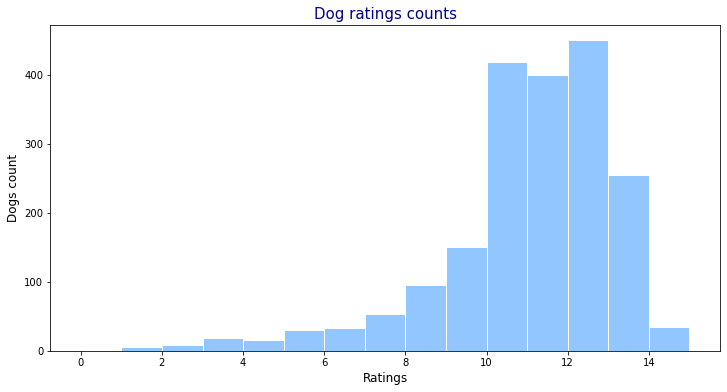

In [144]:
plt.figure(figsize = (12, 6))
plt.style.use('seaborn-pastel')

bins = np.arange(0, 16, 1)
plt.hist(x = archive_clean.rating_numerator, linewidth=1, edgecolor='white', bins=bins)

plt.title('Dog ratings counts', color='darkblue', fontsize=15)
plt.xlabel('Ratings', fontsize=12)
plt.ylabel('Dogs count', fontsize=12)

plt.savefig('.\img\Dogs_ratings_counts')
plt.show()

**The Histogram is heavily skewed right.**

**It seems that the majority rating of dogs are obove 10.**

<a id='fav-rt'></a>
### 5.b Favorites and retweets analysis

In [145]:
archive_clean[['retweet_count' , 'favorite_count']].describe()

,retweet_count,favorite_count
count,1969.000000,1969.000000
mean,2783.673946,8951.310818
std,4699.921113,12273.776070
min,16.000000,81.000000
25%,628.000000,1985.000000
50%,1367.000000,4144.000000
75%,3238.000000,11411.000000
max,79515.000000,132810.000000


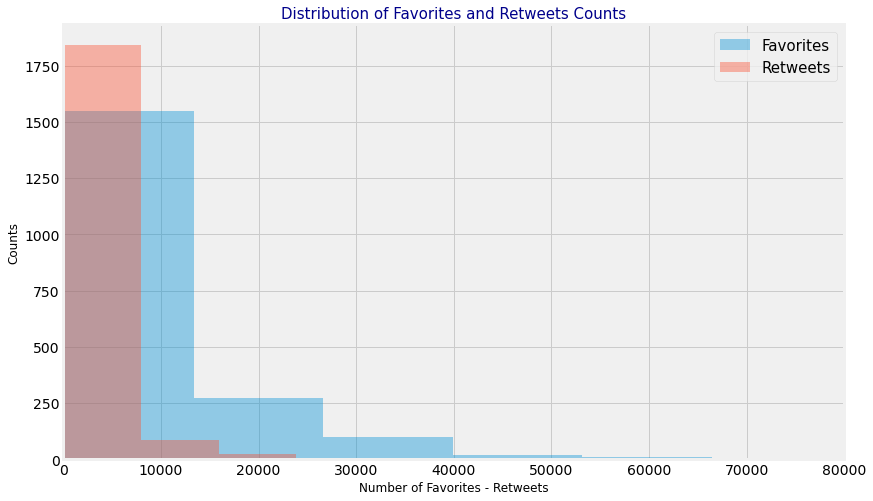

In [146]:
plt.figure(figsize=(14, 8))
plt.style.use('fivethirtyeight')

plt.hist(archive_clean.favorite_count, alpha=.4, label='Favorites')
plt.hist(archive_clean.retweet_count, alpha=.4, label='Retweets')

plt.title('Distribution of Favorites and Retweets Counts', color='darkblue', fontsize=15)
plt.xlabel('Number of Favorites - Retweets', fontsize=12)
plt.ylabel('Counts', fontsize=12)

plt.xlim(-1, 80000)

plt.legend(prop={'size': 15})

plt.savefig('.\img\Favs_retweets_counts')

plt.show()

**Distribution of favorites counts and retweets count follow the same pattern.**

**Let's check correlation.**

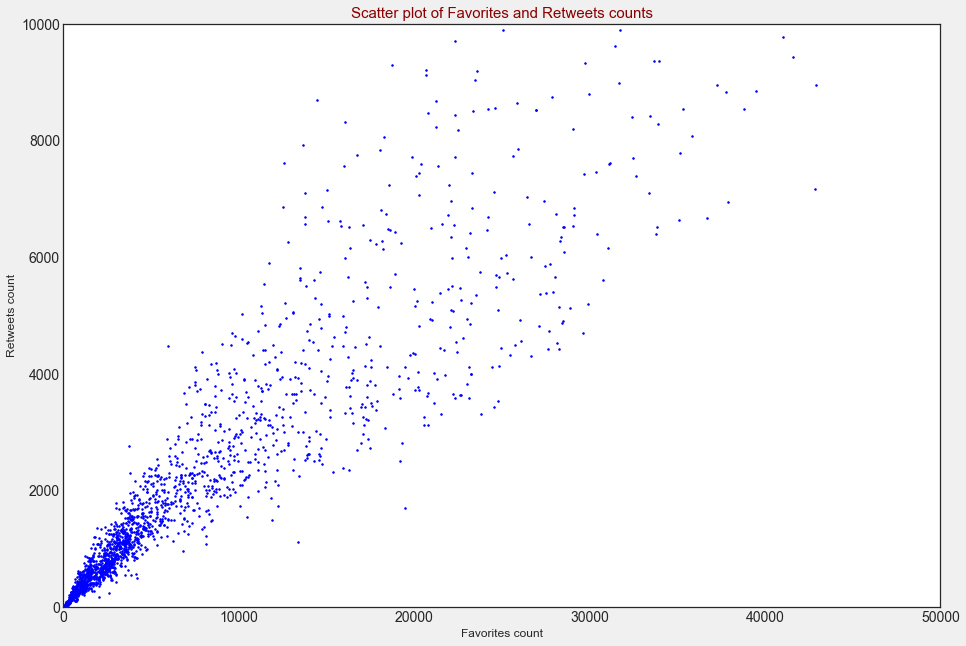

In [147]:
# Scatter plot
plt.figure(figsize=(14, 10))
plt.style.use('seaborn-white')

plt.plot(archive_clean.favorite_count, archive_clean.retweet_count,'bo', markersize=1.5)
plt.title('Scatter plot of Favorites and Retweets counts', color='darkred', fontsize=15)
plt.xlabel('Favorites count', fontsize=12)
plt.ylabel('Retweets count', fontsize=12)

plt.xlim(0, 50000)
plt.ylim(0, 10000)



plt.savefig('.\img\scatter_favs_retweets')
plt.show()

**Good correlation.**

**Check log<sub>10</sub>**

In [148]:
# make copies of dataframes to apply log10
log_df = archive_clean.copy()
log_df = log_df[['favorite_count', 'retweet_count']]
log_df['favorite_count'] = archive_clean.favorite_count.apply(lambda x: np.log10(x))
log_df['retweet_count'] = archive_clean.retweet_count.apply(lambda x: np.log10(x))

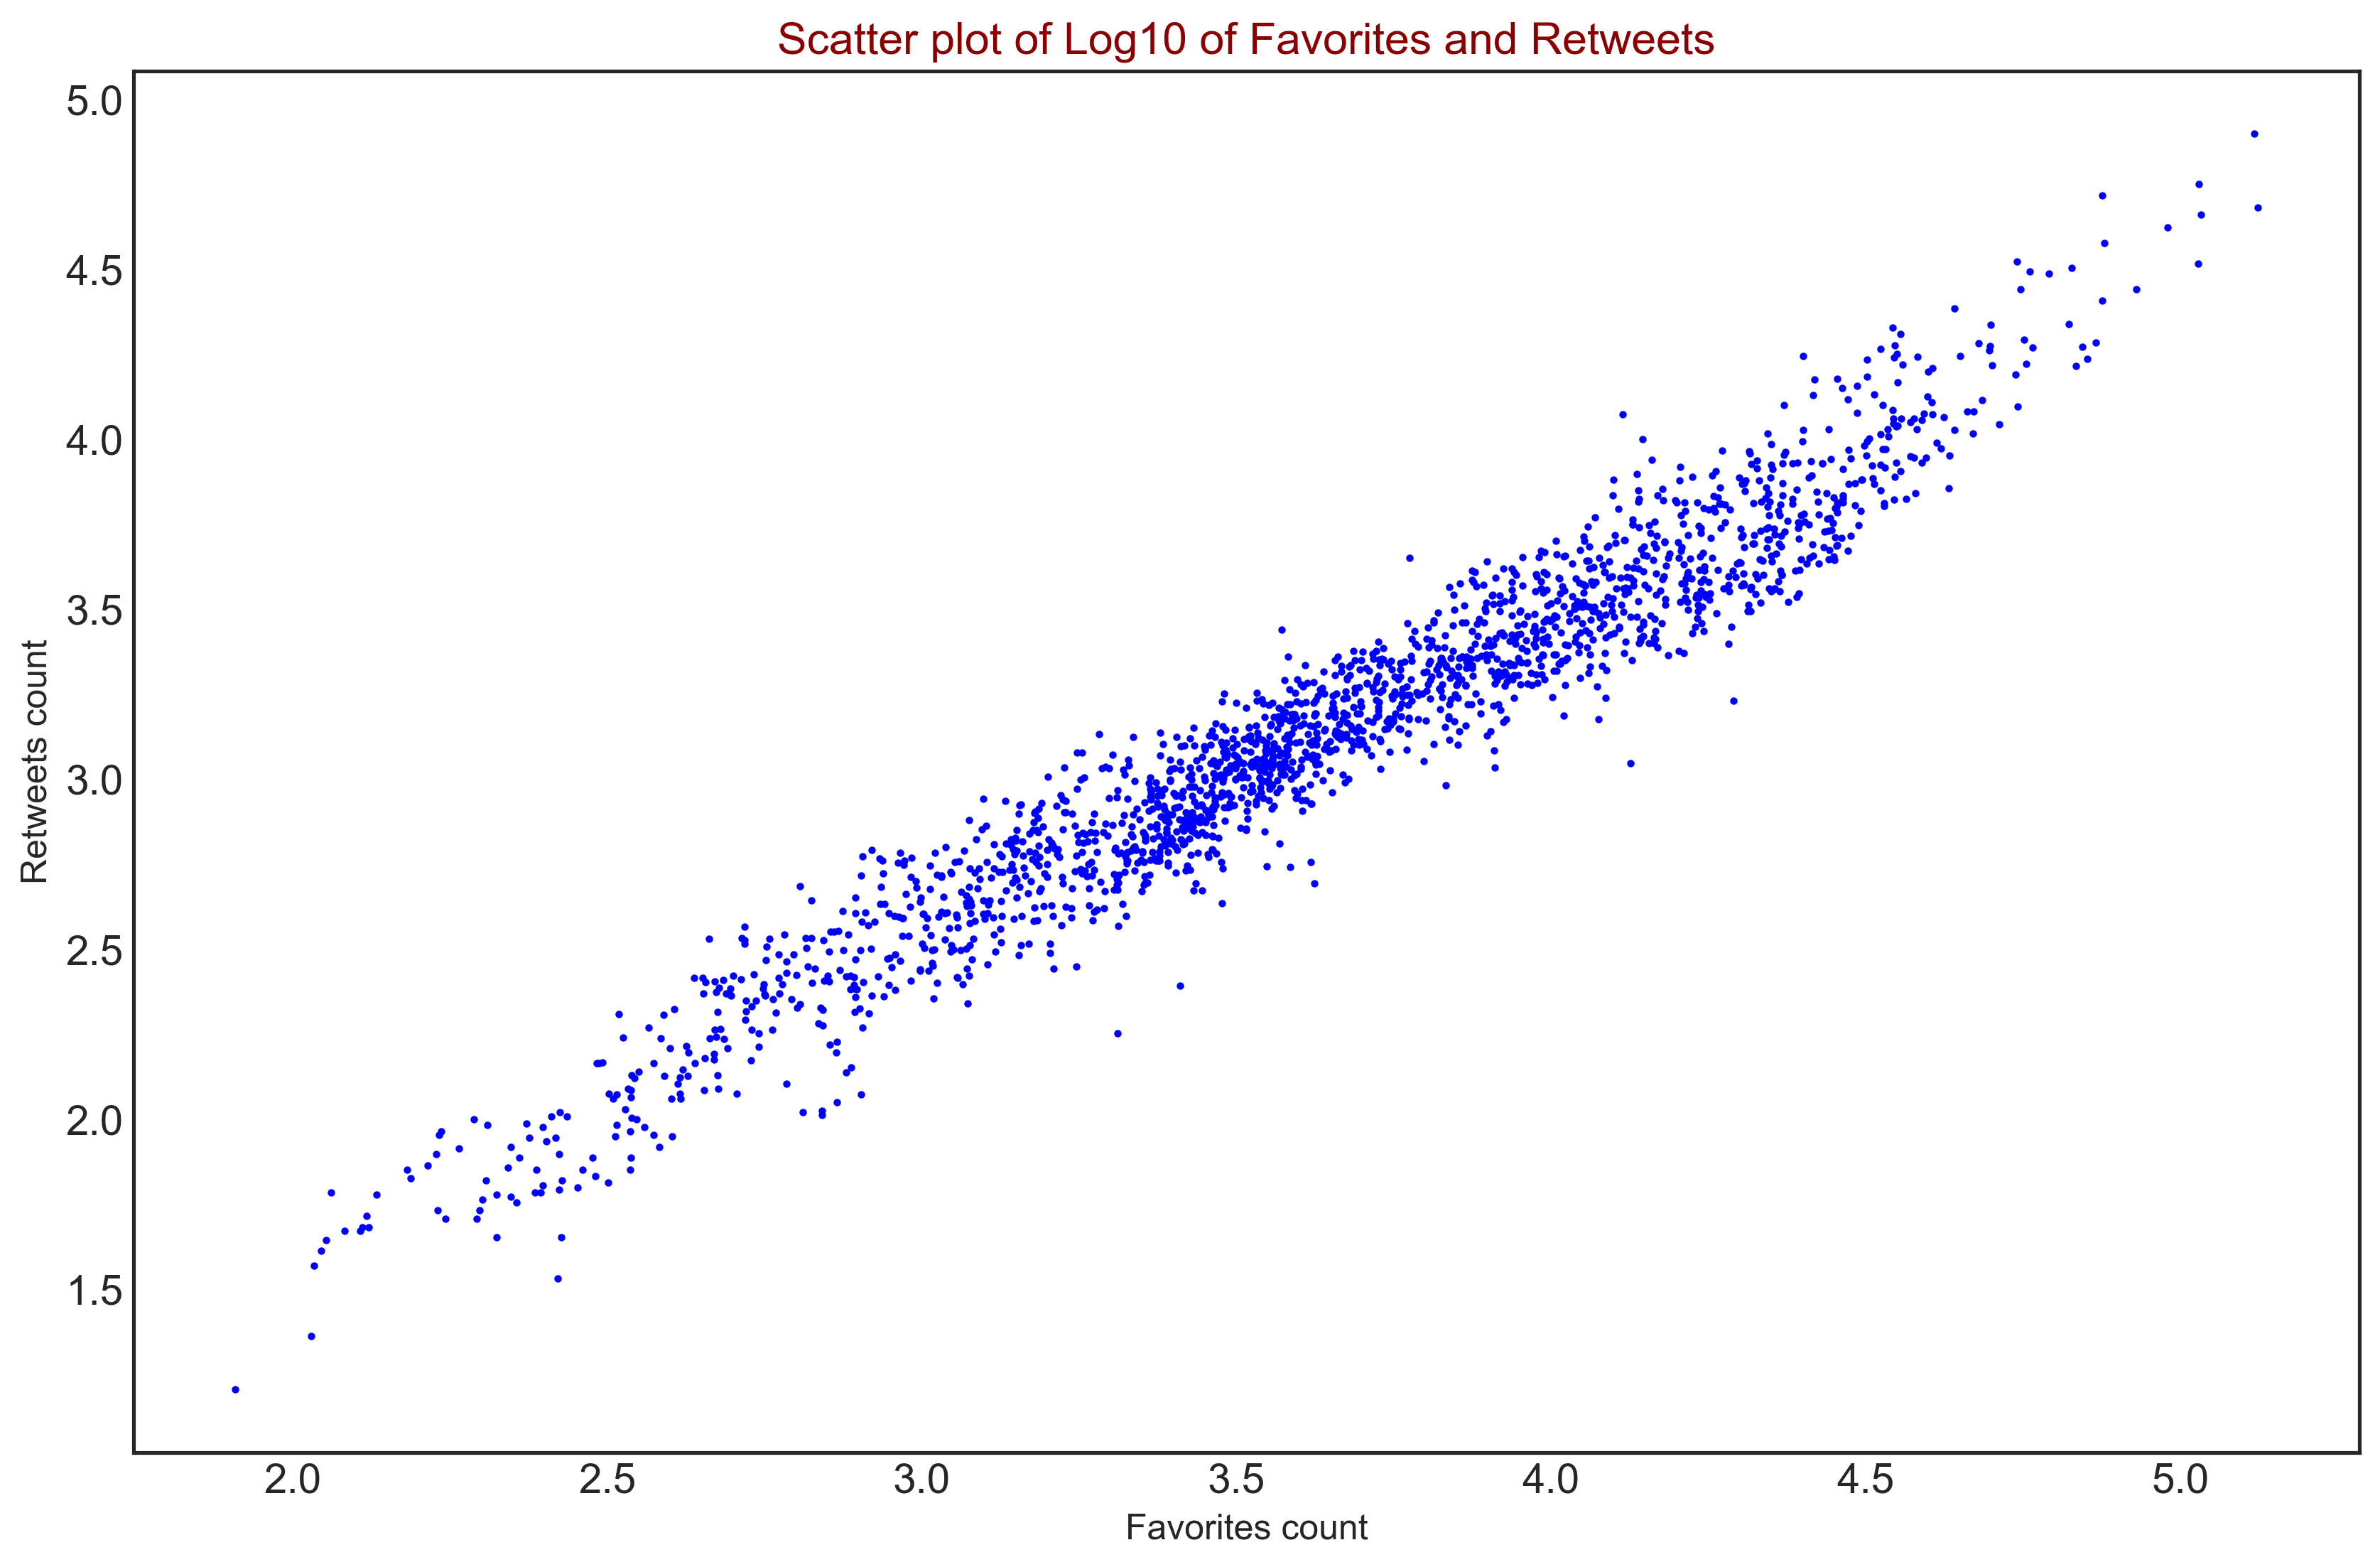

In [149]:
# Plot
plt.figure(figsize=(12, 8), dpi=300)
plt.style.use('seaborn-white')


plt.plot(log_df.favorite_count, log_df.retweet_count, 'bo', markersize=1.5)

plt.title('Scatter plot of Log10 of Favorites and Retweets',color='darkred', fontsize=15)
plt.xlabel('Favorites count', fontsize=12)
plt.ylabel('Retweets count', fontsize=12)


plt.savefig('.\img\Scatter_log-favs_log-retweets')

plt.show()

**People who likes the tweets almost retweets it.**

<a id='month-day'></a>
### 5.c Favorites and retweets analysis by months and days

In [150]:
# Copy
date_df = archive_clean.copy()
date_df = date_df[['timestamp', 'retweet_count' ,'favorite_count']]

# extract 'month' and 'day' columns from timestamp
date_df['month'] = date_df.timestamp.dt.month_name()
date_df['day'] = date_df.timestamp.dt.day_name()

date_df.sample(10)

,timestamp,retweet_count,favorite_count,month,day
391,2017-01-21 18:26:02+00:00,48265.0,132810.0,January,Saturday
490,2016-12-21 01:44:13+00:00,7444.0,23302.0,December,Wednesday
279,2017-03-03 01:14:41+00:00,2631.0,13967.0,March,Friday
580,2016-11-14 17:03:50+00:00,2954.0,11548.0,November,Monday
2000,2015-11-30 15:59:17+00:00,157.0,426.0,November,Monday
600,2016-11-05 15:37:24+00:00,2697.0,11492.0,November,Saturday
825,2016-08-13 00:38:30+00:00,1745.0,6718.0,August,Saturday
2214,2015-11-19 23:53:52+00:00,242.0,559.0,November,Thursday
1258,2016-03-10 20:26:26+00:00,2166.0,4799.0,March,Thursday
1932,2015-12-04 20:38:19+00:00,405.0,1096.0,December,Friday


In [151]:
# number of favorites and retweets by month
month_df = date_df.groupby('month').sum()
month_df

,retweet_count,favorite_count
month,,
April,320884.0,1178300.0
August,232007.0,681425.0
December,837739.0,2142175.0
February,457818.0,1664466.0
January,677532.0,1965498.0
July,552250.0,2166996.0
June,616602.0,2033679.0
March,424441.0,1514301.0
May,440206.0,1561307.0


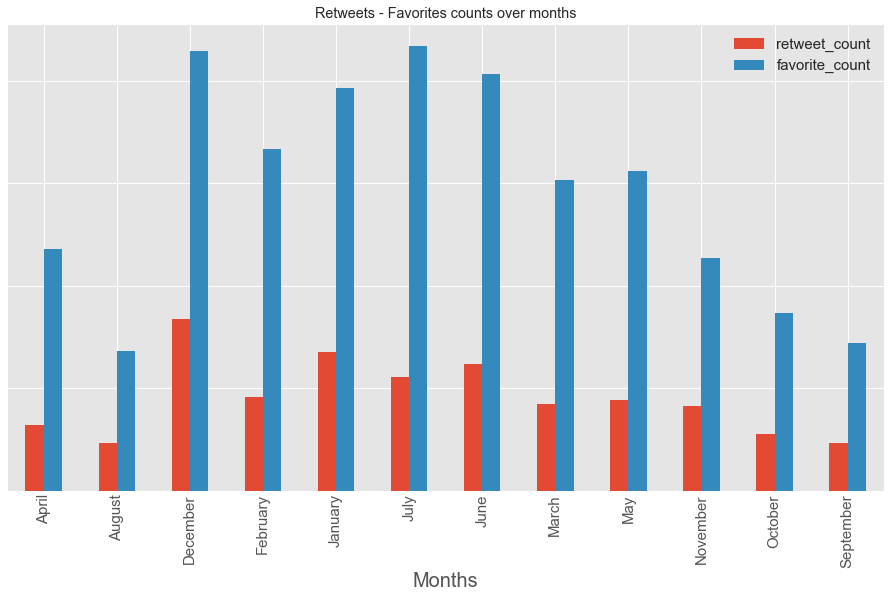

In [152]:
# plot
plt.style.use('ggplot')

ax = month_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over months" ,figsize=(14, 8), legend=True, fontsize=15)

ax.set_xlabel("Months", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})

plt.savefig('.\img\Retweets-favs-months')

**The Highest number of Retweets and Favorites were in January and December.**


In [153]:
# number of favorites and retweets by day
day_df = date_df.groupby('day').sum()
day_df

,retweet_count,favorite_count
day,,
Friday,782096.0,2439293.0
Monday,857298.0,2762536.0
Saturday,742796.0,2248024.0
Sunday,676283.0,2212329.0
Thursday,711520.0,2347013.0
Tuesday,796491.0,2666200.0
Wednesday,914570.0,2949736.0


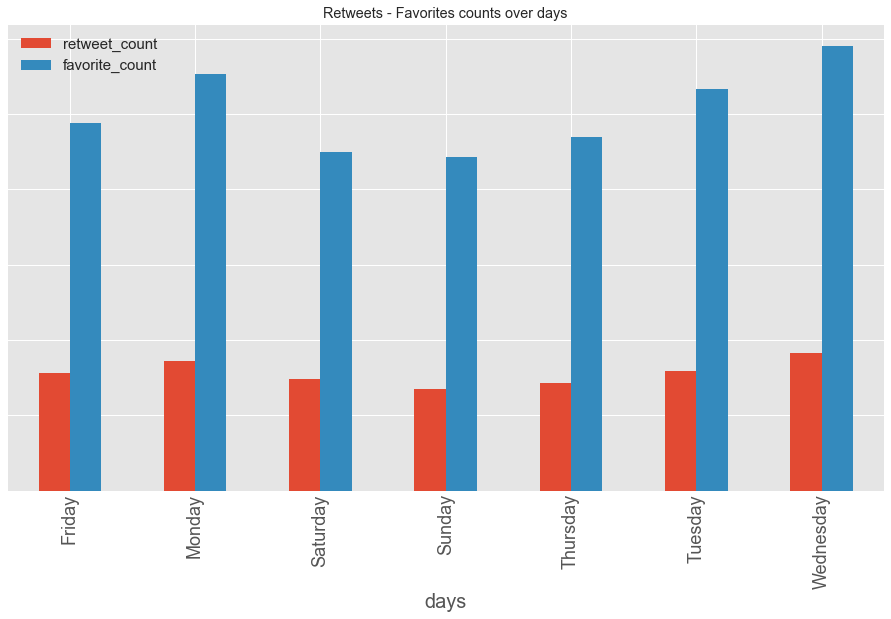

In [154]:
# plot
ax = day_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets - Favorites counts over days", figsize=(14, 8), legend=True, fontsize=18)

ax.set_xlabel("days", fontsize=20)
ax.set_yticklabels([])

plt.legend(prop={'size':15})

plt.savefig('.\img\Retweets-favs-day')

**The Highest number of Retweets and Favorites were on Wednesday.**

 <a id='stage'></a>
 ### 5.d Dog stage analysis

**What is the dog stage has received the largest number of retweets and favorites?**

In [155]:
# df copy
stage_df = archive_clean.groupby('dog_stage').mean()
stage_df = stage_df[['rating_numerator','retweet_count', 'favorite_count']]
stage_df

,rating_numerator,retweet_count,favorite_count
dog_stage,,,
doggo,11.888889,7125.698413,19356.380952
doggo-floofer,11.000000,3433.000000,17169.000000
doggo-pupper,11.000000,4397.250000,13219.875000
doggo-puppo,13.000000,19196.000000,47844.000000
floofer,12.000000,4968.714286,13206.000000
pupper,10.638159,2382.502488,7250.527363
puppo,12.000000,6473.954545,21582.090909


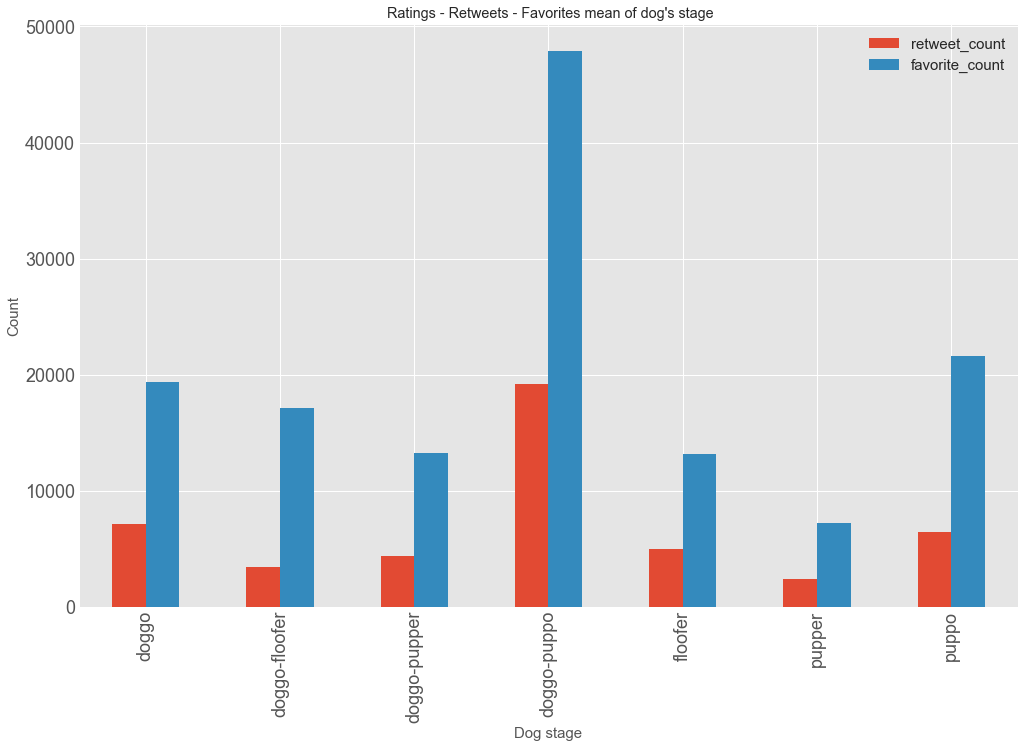

In [156]:
# Plot
ax = stage_df[['retweet_count' , 'favorite_count']].plot(kind='bar', title =" Ratings - Retweets - Favorites mean of dog's stage", figsize=(15, 10), legend=True, fontsize=18)

ax.set_xlabel("Dog stage", fontsize=15)
ax.set_ylabel("Count", fontsize=15)

plt.legend(prop={'size':15})


plt.savefig('.\img\Dog-stage-retweets-favs-rating')

plt.show()

**'puppo' & 'doggo' have received the largest number of retweets and favorites.**

<a id='breed'></a>
### 5.e Dog breed analysis

**Let's figure out which breeds get favorited the most.**

In [157]:
# copy of images
images_copy = image_predictions_clean.copy()
images_copy = images_copy[['tweet_id' ,'prediction_1' ,'confidence_1', 'is_dog_1']]
images_copy.shape

(2075, 4)

In [158]:
# copy of archive 
archive_copy = archive_clean.copy()
archive_copy = archive_copy[['tweet_id' , 'rating_numerator' , 'retweet_count' , 'favorite_count']]
archive_copy.shape

(1969, 4)

In [159]:
# left merge the datasets
breed_clean = pd.merge(left=archive_copy, right=images_copy, on='tweet_id')
breed_clean.shape

(1969, 7)

In [160]:
breed_clean.head()

,tweet_id,rating_numerator,retweet_count,favorite_count,prediction_1,confidence_1,is_dog_1
0,892420643555336193,13.0,8853.0,39467.0,orange,0.097049,False
1,892177421306343426,13.0,6514.0,33819.0,Chihuahua,0.323581,True
2,891815181378084864,12.0,4328.0,25461.0,Chihuahua,0.716012,True
3,891689557279858688,13.0,8964.0,42908.0,paper_towel,0.170278,False
4,891327558926688256,12.0,9774.0,41048.0,basset,0.555712,True


In [161]:
# select only dogs == true
breed_clean = breed_clean[breed_clean['is_dog_1'] == True]

In [162]:
# most favs
breed_fav = breed_clean.groupby('prediction_1').sum().reset_index()
breed_fav = breed_fav[['prediction_1', 'favorite_count']]
breed_fav = breed_fav.sort_values('favorite_count', ascending = False)[:20]
breed_fav

,prediction_1,favorite_count
87,golden_retriever,1693475.0
35,Labrador_retriever,1116811.0
47,Pembroke,994755.0
15,Chihuahua,673526.0
53,Samoyed,542991.0
22,French_bulldog,465738.0
79,chow,404241.0
99,pug,320223.0
81,cocker_spaniel,315825.0
48,Pomeranian,299114.0


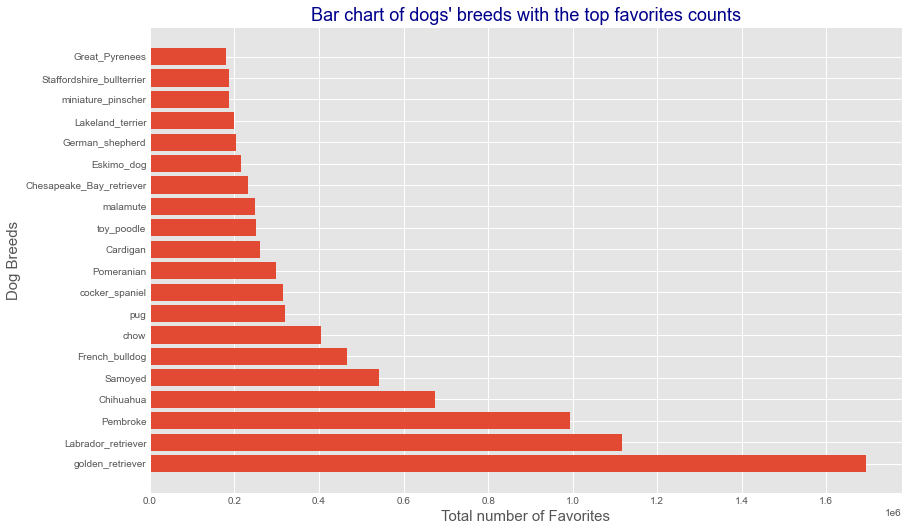

In [163]:
# plot
plt.figure(figsize=(12, 8))
plt.style.use('ggplot')

plt.barh(range(len(breed_fav.prediction_1)), breed_fav.favorite_count) 

plt.yticks(range(len(breed_fav.prediction_1)), breed_fav.prediction_1)

plt.title('Bar chart of dogs\' breeds with the top favorites counts', color = 'darkblue', fontsize=18)

plt.ylabel('Dog Breeds', fontsize=15)
plt.xlabel('Total number of Favorites',fontsize=15)


plt.savefig('.\img\Dog-breed-favs')
plt.show()

**The Golden Retriever has the most amount of favorites, followed by the Labrador Retriever and Pembroke.**

____

![img](https://i0.kym-cdn.com/entries/icons/original/000/008/342/ihave.jpg)

_______